In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import dask.bag as db
import seaborn as sns
import json
# importing Natural Language Toolkit and other NLP modules
import nltk
from nltk.stem import WordNetLemmatizer

# Model selection modules
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import sklearn
#import pyLDAvis


import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch

In [3]:
ai_category_list=['stat.ML','cs.LG','cs.AI']
records=db.read_text("arxiv-metadata-oai-snapshot.json").map(lambda x:json.loads(x))
ai_docs = (records.filter(lambda x:any(ele in x['categories'] for ele in ai_category_list)==True))
get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}

data=ai_docs.map(get_metadata).to_dataframe().compute()


PREPROCESSING

In [4]:
data['DateTime']=pd.to_datetime(data['version'])
data.head()

id                                              title  \
0  0704.0047  Intelligent location of simultaneously active ...   
1  0704.0050  Intelligent location of simultaneously active ...   
2  0704.0304                  The World as Evolving Information   
3  0704.0671              Learning from compressed observations   
4  0704.0954  Sensor Networks with Random Links: Topology De...   

                       category  \
0                   cs.NE cs.AI   
1                   cs.NE cs.AI   
2  cs.IT cs.AI math.IT q-bio.PE   
3           cs.IT cs.LG math.IT   
4           cs.IT cs.LG math.IT   

                                            abstract  \
0    The intelligent acoustic emission locator is...   
1    Part I describes an intelligent acoustic emi...   
2    This paper discusses the benefits of describ...   
3    The problem of statistical learning is to co...   
4    In a sensor network, in practice, the commun...   

                         version                           doi  \
0   Sun, 1 Apr 2007 13:06:50 GMT                          None   
1   Sun, 1 Apr 2007 18:53:13 GMT                          None   
2  Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3   Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4   Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   

                              authors_parsed                  DateTime  
0            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 13:06:50+00:00  
1            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 18:53:13+00:00  
2                   [[Gershenson, Carlos, ]] 2010-10-13 19:49:16+00:00  
3                      [[Raginsky, Maxim, ]] 2007-04-05 02:57:15+00:00  
4  [[Kar, Soummya, ], [Moura, Jose M. F., ]] 2007-04-06 21:58:52+00:00

In [5]:
import pandas as pd

def extractDateFeatures(data, date_column):
    # Convert the date_column to a datetime data type
    data[date_column] = pd.to_datetime(data[date_column])

    # Extract various date-related features
    data['Year'] = data[date_column].dt.year
    data['Month'] = data[date_column].dt.month
    data['Day'] = data[date_column].dt.day
    data['Hour'] = data[date_column].dt.hour
    data['Minute'] = data[date_column].dt.minute
    data['Second'] = data[date_column].dt.second

    # You can add more date-related features as needed

    return data

# Usage example:
# Assuming you have a DataFrame named 'data' with a 'DateTime' column
# Call the function to extract date features
data = extractDateFeatures(data, "DateTime")

# Display the updated DataFrame
data.head()


id                                              title  \
0  0704.0047  Intelligent location of simultaneously active ...   
1  0704.0050  Intelligent location of simultaneously active ...   
2  0704.0304                  The World as Evolving Information   
3  0704.0671              Learning from compressed observations   
4  0704.0954  Sensor Networks with Random Links: Topology De...   

                       category  \
0                   cs.NE cs.AI   
1                   cs.NE cs.AI   
2  cs.IT cs.AI math.IT q-bio.PE   
3           cs.IT cs.LG math.IT   
4           cs.IT cs.LG math.IT   

                                            abstract  \
0    The intelligent acoustic emission locator is...   
1    Part I describes an intelligent acoustic emi...   
2    This paper discusses the benefits of describ...   
3    The problem of statistical learning is to co...   
4    In a sensor network, in practice, the commun...   

                         version                           doi  \
0   Sun, 1 Apr 2007 13:06:50 GMT                          None   
1   Sun, 1 Apr 2007 18:53:13 GMT                          None   
2  Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3   Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4   Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   

                              authors_parsed                  DateTime  Year  \
0            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 13:06:50+00:00  2007   
1            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 18:53:13+00:00  2007   
2                   [[Gershenson, Carlos, ]] 2010-10-13 19:49:16+00:00  2010   
3                      [[Raginsky, Maxim, ]] 2007-04-05 02:57:15+00:00  2007   
4  [[Kar, Soummya, ], [Moura, Jose M. F., ]] 2007-04-06 21:58:52+00:00  2007   

   Month  Day  Hour  Minute  Second  
0      4    1    13       6      50  
1      4    1    18      53      13  
2     10   13    19      49      16  
3      4    5     2      57      15  
4      4    6    21      58      52

In [6]:
data['num_authors']=data['authors_parsed'].apply(lambda x:len(x))

In [7]:
data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])
data.head()

id                                              title  \
0  0704.0047  Intelligent location of simultaneously active ...   
1  0704.0050  Intelligent location of simultaneously active ...   
2  0704.0304                  The World as Evolving Information   
3  0704.0671              Learning from compressed observations   
4  0704.0954  Sensor Networks with Random Links: Topology De...   

                       category  \
0                   cs.NE cs.AI   
1                   cs.NE cs.AI   
2  cs.IT cs.AI math.IT q-bio.PE   
3           cs.IT cs.LG math.IT   
4           cs.IT cs.LG math.IT   

                                            abstract  \
0    The intelligent acoustic emission locator is...   
1    Part I describes an intelligent acoustic emi...   
2    This paper discusses the benefits of describ...   
3    The problem of statistical learning is to co...   
4    In a sensor network, in practice, the commun...   

                         version                           doi  \
0   Sun, 1 Apr 2007 13:06:50 GMT                          None   
1   Sun, 1 Apr 2007 18:53:13 GMT                          None   
2  Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3   Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4   Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   

                              authors_parsed                  DateTime  Year  \
0            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 13:06:50+00:00  2007   
1            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 18:53:13+00:00  2007   
2                   [[Gershenson, Carlos, ]] 2010-10-13 19:49:16+00:00  2010   
3                      [[Raginsky, Maxim, ]] 2007-04-05 02:57:15+00:00  2007   
4  [[Kar, Soummya, ], [Moura, Jose M. F., ]] 2007-04-06 21:58:52+00:00  2007   

   Month  Day  Hour  Minute  Second  num_authors  \
0      4    1    13       6      50            2   
1      4    1    18      53      13            2   
2     10   13    19      49      16            1   
3      4    5     2      57      15            1   
4      4    6    21      58      52            2   

                           authors  
0            [Kosel T., Grabec I.]  
1            [Kosel T., Grabec I.]  
2              [Gershenson Carlos]  
3                 [Raginsky Maxim]  
4  [Kar Soummya, Moura Jose M. F.]

In [8]:
data

id                                              title  \
0              0704.0047  Intelligent location of simultaneously active ...   
1              0704.0050  Intelligent location of simultaneously active ...   
2              0704.0304                  The World as Evolving Information   
3              0704.0671              Learning from compressed observations   
4              0704.0954  Sensor Networks with Random Links: Topology De...   
...                  ...                                                ...   
209118  quant-ph/0205161  Contextualizing Concepts using a Mathematical ...   
209119  quant-ph/0411140     Improved Bounds on Quantum Learning Algorithms   
209120  quant-ph/0507231  Algebras of Measurements: the logical structur...   
209121  quant-ph/0607111  `Plausibilities of plausibilities': an approac...   
209122  quant-ph/0702072                    Markovian Entanglement Networks   

                            category  \
0                        cs.NE cs.AI   
1                        cs.NE cs.AI   
2       cs.IT cs.AI math.IT q-bio.PE   
3                cs.IT cs.LG math.IT   
4                cs.IT cs.LG math.IT   
...                              ...   
209118       quant-ph cs.AI q-bio.NC   
209119                quant-ph cs.LG   
209120                quant-ph cs.AI   
209121                quant-ph cs.AI   
209122                quant-ph cs.AI   

                                                 abstract  \
0         The intelligent acoustic emission locator is...   
1         Part I describes an intelligent acoustic emi...   
2         This paper discusses the benefits of describ...   
3         The problem of statistical learning is to co...   
4         In a sensor network, in practice, the commun...   
...                                                   ...   
209118    We outline the rationale and preliminary res...   
209119    In this article we give several new results ...   
209120    In Quantum Physics, a measurement is represe...   
209121    Probability-like parameters appearing in som...   
209122    Graphical models of probabilistic dependenci...   

                              version                           doi  \
0        Sun, 1 Apr 2007 13:06:50 GMT                          None   
1        Sun, 1 Apr 2007 18:53:13 GMT                          None   
2       Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3        Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4        Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   
...                               ...                           ...   
209118   Fri, 6 Aug 2004 14:23:50 GMT                          None   
209119  Fri, 29 Jul 2005 21:05:02 GMT     10.1007/s11128-005-0001-2   
209120   Thu, 8 Dec 2005 13:50:45 GMT     10.1007/s10773-006-9062-y   
209121  Sun, 29 Apr 2007 12:09:41 GMT                          None   
209122   Wed, 7 Feb 2007 18:39:42 GMT                          None   

                                           authors_parsed  \
0                         [[Kosel, T., ], [Grabec, I., ]]   
1                         [[Kosel, T., ], [Grabec, I., ]]   
2                                [[Gershenson, Carlos, ]]   
3                                   [[Raginsky, Maxim, ]]   
4               [[Kar, Soummya, ], [Moura, Jose M. F., ]]   
...                                                   ...   
209118           [[Gabora, Liane, ], [Aerts, Diederik, ]]   
209119           [[Atici, Alp, ], [Servedio, Rocco A., ]]   
209120  [[Lehmann, Daniel, ], [Engesser, Kurt, ], [Gab...   
209121  [[Mana, P. G. L. Porta, ], [Månsson, A., ], [B...   
209122  [[La Mura, Pierfrancesco, ], [Swiatczak, Lukas...   

                        DateTime  Year  Month  Day  Hour  Minute  Second  \
0      2007-04-01 13:06:50+00:00  2007      4    1    13       6      50   
1      2007-04-01 18:53:13+00:00  2007      4    1    18      53      13   
2      2010-10-13 19:49:16+00:00  2010     10

In [9]:
data['category'].unique()

array(['cs.NE cs.AI', 'cs.IT cs.AI math.IT q-bio.PE',
       'cs.IT cs.LG math.IT', ..., 'quant-ph cond-mat.dis-nn cs.AI q-bio',
       'quant-ph cond-mat.dis-nn cs.AI', 'quant-ph cs.AI q-bio.NC'],
      dtype=object)

In [10]:
import pandas as pd

# Assuming 'data' is your DataFrame
# If 'data' is not already loaded, you can load your data using pd.read_csv or another appropriate method

# Extract unique categories from the 'category' column
unique_categories = data['category'].unique()

# Specify the path to the text file where you want to store the categories
output_file_path = 'categories.txt'

# Write the unique categories to the text file
with open(output_file_path, 'w') as file:
    for category in unique_categories:
        file.write(f"{category}\n")

print(f"Unique categories have been saved to {output_file_path}")


Unique categories have been saved to categories.txt


/var/folders/8q/zhv12ptn3p578l9zhh2z5p_00000gn/T/ipykernel_39981/2403130789.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['abstract_len']).set_title('Length Distribution');


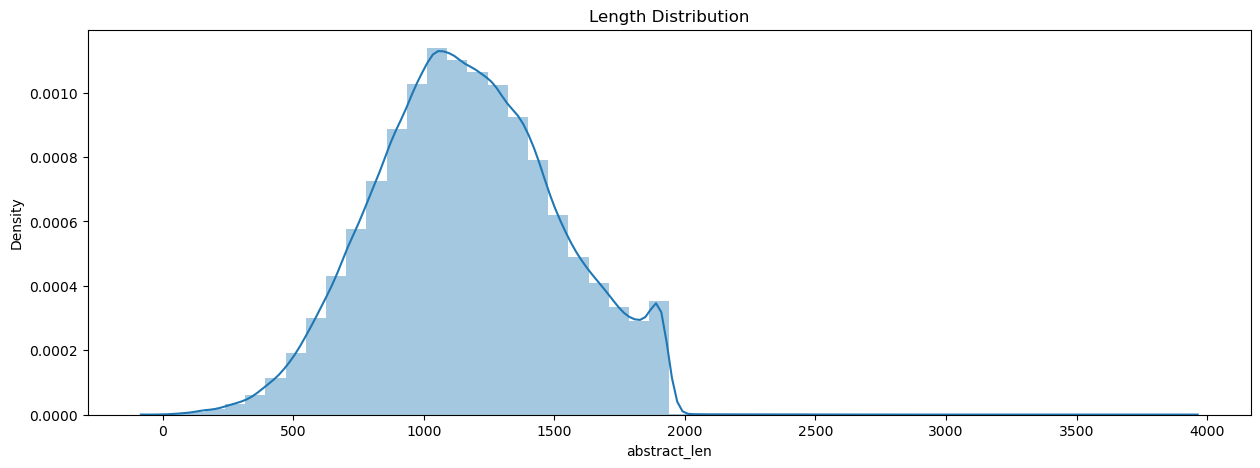

In [11]:
data['abstract_len'] = data['abstract'].str.len()
plt.figure(figsize=(15, 5))
sns.distplot(data['abstract_len']).set_title('Length Distribution');

In [12]:
#Checking the number of Article per categories:
cat_count =data.groupby('category')['category'].count().sort_values(ascending=False)
cat_count

category
cs.LG                                      14599
cs.LG stat.ML                              13987
cs.AI                                       9292
cs.LG cs.AI                                 7082
stat.ML cs.LG                               6763
                                           ...  
cs.LG cs.CR cs.DC cs.GT                        1
cs.LG cs.CR cs.DC cs.GT stat.ML                1
cs.LG cs.CR cs.DC cs.IT eess.SP math.IT        1
cs.LG cs.CR cs.DC cs.MA                        1
cs.LG hep-th nlin.CD physics.flu-dyn           1
Name: category, Length: 17070, dtype: int64

In [13]:
#Removing the punctuations from our corpuses

def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space,
    # which in effect deletes the punctuation marks
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [14]:
data['abstract'] = data['abstract'].apply(remove_punctuation)


In [17]:
# Function to extract top n words with highest frequency
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    The function returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample as inputs
    '''
    # encoding the document using countvectorizer object
    vectorized_content = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_content, axis=0)

    # extracting specifics for words
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    # creating a vector matrix for words
    word_vectors = np.zeros((n_top_words, vectorized_content.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    # display Vector matrix
    print(word_vectors)

    # collect the words
    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [18]:
# Removing stopword using NLTK:
# dowloading nltk stopwords module
nltk.download('stopwords')
# extracting all stopwords for english language
stop = nltk.corpus.stopwords.words('english')
stop[0:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyothi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [19]:
# creating vectorizer object
count_vectorizer = CountVectorizer(stop_words=stop)

# calling the function to get words and their counts
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer,
                                     text_data=content)
# display top 25 words using bar plot
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values, edgecolor='red')
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in dataset (excluding stop words)')
ax.set_xlabel('Words')
ax.set_ylabel('Number of occurences')
plt.show()

NameError: name 'content' is not defined

In [20]:
def label_category(category):
    if 'cs.AI' in category and ('stat.ML' in category or 'cs.LG' in category):
        return 'Artificial Intelligence and Machine Learning'
    elif 'cs.AI' in category:
        return 'Artificial Intelligence'
    elif 'stat.ML' in category or 'cs.LG' in category:
        return 'Machine Learning'
    else:
        return None


In [21]:
# data.drop(columns=['new_category_label'], inplace=True)

In [22]:
data['new_category_label'] = data['category'].apply(label_category)

In [23]:
data

id                                              title  \
0              0704.0047  Intelligent location of simultaneously active ...   
1              0704.0050  Intelligent location of simultaneously active ...   
2              0704.0304                  The World as Evolving Information   
3              0704.0671              Learning from compressed observations   
4              0704.0954  Sensor Networks with Random Links: Topology De...   
...                  ...                                                ...   
209118  quant-ph/0205161  Contextualizing Concepts using a Mathematical ...   
209119  quant-ph/0411140     Improved Bounds on Quantum Learning Algorithms   
209120  quant-ph/0507231  Algebras of Measurements: the logical structur...   
209121  quant-ph/0607111  `Plausibilities of plausibilities': an approac...   
209122  quant-ph/0702072                    Markovian Entanglement Networks   

                            category  \
0                        cs.NE cs.AI   
1                        cs.NE cs.AI   
2       cs.IT cs.AI math.IT q-bio.PE   
3                cs.IT cs.LG math.IT   
4                cs.IT cs.LG math.IT   
...                              ...   
209118       quant-ph cs.AI q-bio.NC   
209119                quant-ph cs.LG   
209120                quant-ph cs.AI   
209121                quant-ph cs.AI   
209122                quant-ph cs.AI   

                                                 abstract  \
0         The intelligent acoustic emission locator is...   
1         Part I describes an intelligent acoustic emi...   
2         This paper discusses the benefits of describ...   
3         The problem of statistical learning is to co...   
4         In a sensor network in practice the communic...   
...                                                   ...   
209118    We outline the rationale and preliminary res...   
209119    In this article we give several new results ...   
209120    In Quantum Physics a measurement is represen...   
209121    Probabilitylike parameters appearing in some...   
209122    Graphical models of probabilistic dependenci...   

                              version                           doi  \
0        Sun, 1 Apr 2007 13:06:50 GMT                          None   
1        Sun, 1 Apr 2007 18:53:13 GMT                          None   
2       Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3        Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4        Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   
...                               ...                           ...   
209118   Fri, 6 Aug 2004 14:23:50 GMT                          None   
209119  Fri, 29 Jul 2005 21:05:02 GMT     10.1007/s11128-005-0001-2   
209120   Thu, 8 Dec 2005 13:50:45 GMT     10.1007/s10773-006-9062-y   
209121  Sun, 29 Apr 2007 12:09:41 GMT                          None   
209122   Wed, 7 Feb 2007 18:39:42 GMT                          None   

                                           authors_parsed  \
0                         [[Kosel, T., ], [Grabec, I., ]]   
1                         [[Kosel, T., ], [Grabec, I., ]]   
2                                [[Gershenson, Carlos, ]]   
3                                   [[Raginsky, Maxim, ]]   
4               [[Kar, Soummya, ], [Moura, Jose M. F., ]]   
...                                                   ...   
209118           [[Gabora, Liane, ], [Aerts, Diederik, ]]   
209119           [[Atici, Alp, ], [Servedio, Rocco A., ]]   
209120  [[Lehmann, Daniel, ], [Engesser, Kurt, ], [Gab...   
209121  [[Mana, P. G. L. Porta, ], [Månsson, A., ], [B...   
209122  [[La Mura, Pierfrancesco, ], [Swiatczak, Lukas...   

                        DateTime  Year  Month  Day  Hour  Minute  Second  \
0      2007-04-01 13:06:50+00:00  2007      4    1    13       6      50   
1      2007-04-01 18:53:13+00:00  2007      4    1    18      53      13   
2      2010-10-13 19:49:16+00:00  2010     10

#BERT


In [24]:
!pip install bertopic

In [25]:
import pandas as pd
from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer

In [ ]:
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(data['abstract']); 
len(topic_model.get_topic_info())

2023-12-15 19:06:22,909 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/6536 [00:00<?, ?it/s]

In [160]:
topic_model.get_topic_info().head(10)

Topic  Count                                          Name  \
0     -1  88950                -1_model_learning_network_data   
1      0   4018                0_traffic_vehicle_driving_road   
2      1   3234           1_robot_robotic_manipulation_object   
3      2   3110  2_adversarial_attack_perturbation_robustness   
4      3   2899                  3_fl_federated_client_server   
5      4   2687         4_sgd_stochastic_gradient_convergence   
6      5   2670                     5_regret_bandit_arm_bound   
7      6   2389       6_causal_treatment_effect_observational   
8      7   1945             7_privacy_private_dp_differential   
9      8   1917               8_bayesian_posterior_mcmc_carlo   

                                      Representation  \
0  [model, learning, network, data, problem, meth...   
1  [traffic, vehicle, driving, road, autonomous, ...   
2  [robot, robotic, manipulation, object, environ...   
3  [adversarial, attack, perturbation, robustness...   
4  [fl, federated, client, server, privacy, local...   
5  [sgd, stochastic, gradient, convergence, conve...   
6  [regret, bandit, arm, bound, multiarmed, rewar...   
7  [causal, treatment, effect, observational, cau...   
8  [privacy, private, dp, differential, different...   
9  [bayesian, posterior, mcmc, carlo, monte, infe...   

                                 Representative_Docs  
0  [transfer recent advance deep reinforcement le...  
1  [need accurately estimate speed road vehicle b...  
2  [key challenge robotic manipulation open domai...  
3  [wide range defense proposed harden neural net...  
4  [federated learning fl important paradigm trai...  
5  [study generalization property popular stochas...  
6  [multiarmed bandit mab model sequential decisi...  
7  [core causal inference lie challenge determini...  
8  [building recommendation system involves analy...  
9  [bayesian statistic many problem expressed eva...

In [239]:
topic_model.get_topic(0)

[('traffic', 0.02484457256334417),
 ('vehicle', 0.01968337390656602),
 ('driving', 0.017447196784722077),
 ('road', 0.012647827839645898),
 ('autonomous', 0.011092224986817882),
 ('driver', 0.010207778834391473),
 ('trajectory', 0.009951913901839438),
 ('urban', 0.009579590256462274),
 ('spatiotemporal', 0.007758768954547022),
 ('transportation', 0.007181280484698644)]

In [243]:
topic_model.get_topic(30)

[('diffusion', 0.07517345236064614),
 ('denoising', 0.013062055292593577),
 ('generation', 0.012758715084981028),
 ('image', 0.011478953013295892),
 ('generative', 0.010502284057657024),
 ('texttoimage', 0.010252406340294146),
 ('sampling', 0.008045880913797215),
 ('editing', 0.00748512289258146),
 ('diffusionbased', 0.007421716536952434),
 ('guidance', 0.007102578844108934)]

In [241]:
topic_model.visualize_barchart(top_n_topics=9,height=700)

In [163]:
topic_model.visualize_topics()

In [169]:
# model.get_topic_info().head(10)
freq=topic_model.get_topic_info()
print("Number of topics: {}".format(len(freq)))
freq.head()

Number of topics: 367


Topic  Count                                          Name  \
0     -1  88950                -1_model_learning_network_data   
1      0   4018                0_traffic_vehicle_driving_road   
2      1   3234           1_robot_robotic_manipulation_object   
3      2   3110  2_adversarial_attack_perturbation_robustness   
4      3   2899                  3_fl_federated_client_server   

                                      Representation  \
0  [model, learning, network, data, problem, meth...   
1  [traffic, vehicle, driving, road, autonomous, ...   
2  [robot, robotic, manipulation, object, environ...   
3  [adversarial, attack, perturbation, robustness...   
4  [fl, federated, client, server, privacy, local...   

                                 Representative_Docs  
0  [transfer recent advance deep reinforcement le...  
1  [need accurately estimate speed road vehicle b...  
2  [key challenge robotic manipulation open domai...  
3  [wide range defense proposed harden neural net...  
4  [federated learning fl important paradigm trai...

In [221]:
a_topic=freq.iloc[3]["Topic"]
model.get_topic(a_topic)

[('adversarial', 0.018365812426726663),
 ('attack', 0.012704425865255638),
 ('perturbation', 0.011435809457770448),
 ('defense', 0.010133654595952231),
 ('robustness', 0.007940330243002018),
 ('example', 0.0058355763587374975),
 ('vulnerable', 0.005115374706441652),
 ('transferability', 0.004553774587601247),
 ('robust', 0.004138291283951628),
 ('blackbox', 0.00411516532769032)]

In [240]:

# Increase the number of words per topic to, for example, 10
# Assuming topic_model is an instance of BERTopic and you have the correct version
# topic_model.update_topics(data['abstract'], topics, n_gram_range=(1, 2), nr_words=10)

# # Now visualize without specifying nr_words
# topic_model.visualize_barchart(top_n_topics=9, height=700)



In [165]:
topic_model.visualize_term_rank()

In [167]:
topic_model.visualize_hierarchy(top_n_topics=50, width=800)

In [168]:
topic_model.visualize_heatmap(n_clusters=20, top_n_topics=100)

In [217]:
timestamps = data['Year'].tolist()

topics_over_time = topic_model.topics_over_time(data['abstract'],timestamps)


31it [02:07,  4.12s/it]


In [219]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50, width=900, height=500)

In [213]:
cat = data['new_category_label'].tolist()
cat

['Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Machine Learning',
 'Machine Learning',
 'Artificial Intelligence',
 'Machine Learning',
 'Artificial Intelligence and Machine Learning',
 'Machine Learning',
 'Machine Learning',
 'Artificial Intelligence',
 'Artificial Intelligence and Machine Learning',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Machine Learning',
 'Artificial Intelligence',
 'Machine Learning',
 'Machine Learning',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Machine Learning',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Artificial 

In [214]:
# Correctly call the topics_per_class method
topics_per_class = topic_model.topics_per_class(docs=data['abstract'], classes=cat)

3it [00:07,  2.40s/it]


In [216]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10, width=900)

In [232]:
# Get the most frequent words per topic
topic_words = topic_model.get_topic_info()

# Convert to the format expected by Gensim CoherenceModel
topics_gensim = []
for _, row in topic_words.iterrows():
    if row['Name'] != -1:  # Exclude the outlier topic if present
        words = model.get_topic(row['Topic'])
        topics_gensim.append([word for word, _ in words])


In [237]:
docs = data['abstract'].tolist()

In [238]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import nltk
nltk.download('stopwords')

# Tokenize your documents
texts = [[word for word in doc.lower().split() if word not in gensim.parsing.preprocessing.STOPWORDS]
         for doc in docs]

# Create a Gensim Dictionary and Corpus
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate Coherence
coherence_model = CoherenceModel(topics=topics_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print('Coherence Score: ', coherence)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyothi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 